In [1]:
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
import time
import sympy as sym
fontsizes=18
plt.rcParams.update({'font.size': fontsizes})
plt.rcParams.update({"font.family": "serif"})
plt.rcParams.update({"mathtext.fontset" : "cm"})
plt.rcParams.update({'font.serif': 'Times New Roman'})
plt.close('all')


Bad key "text.kerning_factor" on line 4 in
/Users/jorgemen/anaconda3/envs/py3k/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# =============================================================================
# INPUT

b = 50                          # [mm] Cross-section width
E = 205000                      # [MPa] Elastic modulus
l = 3000                        # [mm] Beam span
mu_H = 100                      # [mm] Cross-section height mean
sigma_H = 5                     # [mm] Cross-section height std. dev.
mu_Q = 5                        # [N/mm] Mean load
sigma_Q = 1                     # [N/mm] Std. load
w_max = 8                       # [mm] 5/384*ql^4/EI

c0 = 5*l**4/(384*E*b/12)

In [3]:
# Plot limit state function
# plot x-space

MU = np.array([mu_Q,mu_H])
CX = np.array([[sigma_Q**2, 0],
              [0, sigma_H**2]])

fx = lambda X: mvn(MU,CX).pdf(X)

dum_Q = np.linspace(0,mu_Q+5*sigma_Q,100)
dum_H = np.linspace(0,mu_H+10*sigma_H,100)
X1, X2 = np.meshgrid(dum_Q,dum_H, indexing='ij')
X = np.dstack((X1, X2))

Text(0.5, 0, 'H')

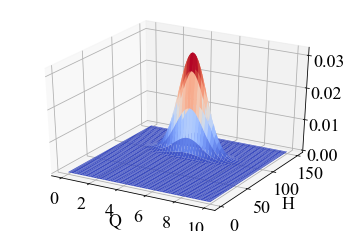

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1,X2,fx(X),cmap=cm.coolwarm)
ax.set_xlabel('Q')
ax.set_ylabel('H')

Limit state function in the x-space

In [5]:
q_lsf = lambda h: w_max*h**3/c0     # LSF

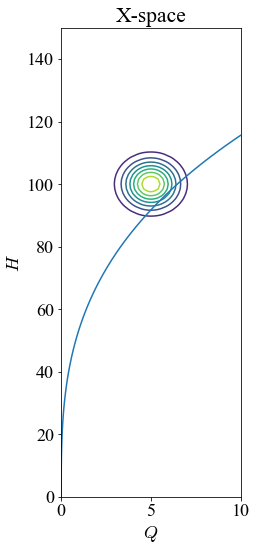

In [6]:
wp, hp = figaspect(2/1)
fig, ax1 = plt.subplots(1, 1,figsize=(wp,hp))
ax1.contour(X1, X2, fx(X))
ax1.plot(q_lsf(dum_H),dum_H);
ax1.set_xlim(0,dum_Q[-1])
ax1.set_ylim(0,dum_H[-1])
ax1.set_title('X-space')
ax1.set_xlabel('$Q$')
ax1.set_ylabel('$H$')
plt.tight_layout()

Limit state function in the u-space

In [7]:
uq_lsf = lambda uh: w_max*(uh*sigma_H + mu_H)**3/c0/sigma_Q - mu_Q/sigma_Q

In [8]:
# Plot limit state function
# plot u-space

MU_U = np.array([0,0])
CU = np.array([[1, 0],
              [0, 1]])

fu = lambda U: mvn(MU_U,CU).pdf(U)

dum_U = np.linspace(-5,5,100)
U1, U2 = np.meshgrid(dum_U,dum_U, indexing='ij')
U = np.dstack((U1, U2))

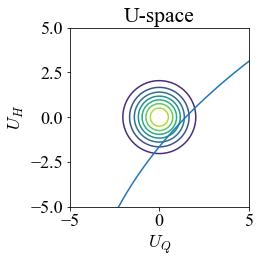

In [9]:
fig, ax1 = plt.subplots(1, 1)
ax1.contour(U1, U2, fu(U))
ax1.plot(uq_lsf(dum_U),dum_U);
ax1.set_xlim(dum_U[0],dum_U[-1])
ax1.set_ylim(dum_U[0],dum_U[-1])
ax1.set_title('U-space')
ax1.set_xlabel('$U_Q$')
ax1.set_ylabel('$U_H$')
ax1.set_aspect('equal')
plt.tight_layout()

In [10]:
gu = lambda u: u[1]**3 + 60*u[1]**2 + 1200*u[1] - 1235*u[0] + 1825
tol = 1e-5
alpha0 = np.array([1/np.sqrt(2),-1/np.sqrt(2)])

In [11]:
def alpha_next(u):
    dgdu1 = -1235
    dgdu2 = 3*u[1]**2 + 120*u[1] + 1200
    k = unp.sqrt(dgdu1**2+dgdu2**2)
    return np.array([-dgdu1/k,-dgdu2/k])

In [12]:
def gumbmom2param(moments):
    a = np.pi/np.sqrt(6)/moments[1]
    b = moments[0] - 0.5772/a
    theta = [a,b]
    return theta

In [13]:
theta_Q = gumbmom2param([mu_Q,sigma_Q])
print(theta_Q)

[1.282549830161864, 4.5499590063279225]


In [14]:
def lnmom2param(moments):
    sigma_ln = np.sqrt(np.log(moments[1]**2/moments[0]**2+1))
    mu_ln = np.log(moments[0])-0.5*sigma_ln**2
    theta = [mu_ln,sigma_ln]
    return theta

In [15]:
theta_H = lnmom2param([mu_H,sigma_H])
print(theta_H)

[4.603921745888798, 0.049968792246632754]


In [16]:
def x2u(X):
    if X['type'] is "Gumbel":
        XTransform = lambda u: X['theta'][1]-1/X['theta'][0]*np.log(-np.log(sp.stats.norm.cdf(u)))
    if X['type'] is "Normal":
        XTransform = lambda u: u * X['theta'][1] + X['theta'][0]
    if X['type'] is "Lognormal":
        XTransform = lambda u: np.exp(X['theta'][1]*u + X['theta'][0])
    return XTransform

In [113]:
Q = {}
Q['type'] = "Gumbel"
Q['moments'] = [mu_Q,sigma_Q]
Q['theta'] = gumbmom2param(Q['moments'])

H = {}
H['type'] = "Lognormal"
H['moments'] = [mu_H,sigma_H]
H['theta'] = lnmom2param(H['moments'])

In [114]:
gX = lambda x: w_max*x[1]**3 - c0*x[0]
gU1 = lambda u: gX( [ x2u(Q)(u[0]), x2u(H)(u[1]) ] )

In [115]:
print(gX([1,2]))
print(gU1([1,2]))

-1234692.0975609757
3447941.504337185


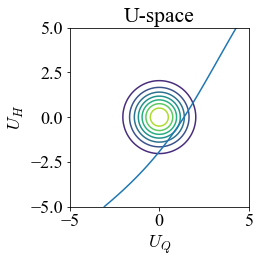

In [116]:
dum_U1 = []
for i in range(len(dum_U)):
    gU_plot = lambda u1: gU1([u1,dum_U[i]])
    res = sp.optimize.root(gU_plot,dum_U[i])
    dum_U1.append(res.x)
    
fig, ax1 = plt.subplots(1, 1)
ax1.contour(U1, U2, fu(U))
ax1.plot(dum_U1,dum_U);
ax1.set_xlim(dum_U[0],dum_U[-1])
ax1.set_ylim(dum_U[0],dum_U[-1])
ax1.set_title('U-space')
ax1.set_xlabel('$U_Q$')
ax1.set_ylabel('$U_H$')
ax1.set_aspect('equal')
plt.tight_layout()

In [117]:
def dxdufun(X):
    if X['type'] is "Gumbel":
        dxdu = lambda u: - sp.stats.norm.pdf(u)/(X['theta'][0] * sp.stats.norm.cdf(u)*np.log(sp.stats.norm.cdf(u)))
    if X['type'] is "Normal":
        dxdu = lambda u: X['theta'][1]
    if X['type'] is "Lognormal":
        dxdu = lambda u: X['theta'][1] * np.exp(X['theta'][0]+X['theta'][1] * u)
    return dxdu

In [118]:
def alpha_next(u):
    dgdu1 = -c0 * dxdufun(Q)(u[0])
    dgdu2 = w_max * 3 * (x2u(H)(u[1]))**2 * dxdufun(H)(u[1])
    k = np.sqrt(dgdu1**2+dgdu2**2)
    return np.array([-dgdu1/k,-dgdu2/k])

In [119]:
print(alpha_next(alpha0))

[ 0.80051557 -0.59931196]
